In [4]:
# !pip install tensorflow
# !pip install tensorflow_probability
# !pip install tqdm

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from scipy.stats import multivariate_normal 

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from IPython.display import clear_output

In [31]:
def em(dataset, n_clusters, n_iter=100):
    # Infer from the dataset
    n_samples, n_dims = dataset.shape

    # Draw initial guesses
    cluster_probs = tfp.distributions.Dirichlet(tf.ones(n_clusters)).sample(seed=42)
    mus = tfp.distributions.Normal(loc=0.0, scale=3.0).sample((n_clusters, n_dims), seed=42)
    covs = tfp.distributions.WishartTriL(df=3, scale_tril=tf.eye(n_dims)).sample(n_clusters, seed=42)
    
    print(n_clusters, mus.shape, covs.shape)
    X = dataset.numpy()
    for _ in range(n_iter):
        # Batched Cholesky Factorization
        # Ls = tf.linalg.cholesky(covs)
        # normals = tfp.distributions.MultivariateNormalTriL(
        #     loc=mus,
        #     scale_tril=covs #Ls
        # )
        ## Numpy
        unnormalized_responsibilities = np.array([multivariate_normal(mean=mean, cov=cov).pdf(X) for mean, cov in zip(mus, covs)]).T
        y = np.array([multivariate_normal(mean=mean, cov=cov).pdf(X) for mean, cov in zip(mus, covs)]).T
        
        # print(f"Unnormalized: {unnormalized_responsibilities}")

        # unnormalized_responsibilities = tf.convert_to_tensor(unnormalized_responsibilities)
        # unnormalized_responsibilities = tf.cast(unnormalized_responsibilities, dtype=tf.float32)
        ### E-Step

        # (1) resp is of shape (n_samples x n_clusters)
        # batched multivariate normal is of shape (n_clusters x n_dims)
        # unnormalized_responsibilities = (
        #     tf.reshape(cluster_probs, (1, n_clusters)) * normals.prob(tf.reshape(dataset, (n_samples, 1, n_dims)))
        # )
        # print(f"Unnormalized (tensor): {unnormalized_responsibilities.shape}")
        # responsibilities = unnormalized_responsibilities / tf.reduce_sum(unnormalized_responsibilities, axis=1, keepdims=True)

        ## Numpy
        norms = np.linalg.norm(unnormalized_responsibilities, axis=1, keepdims=True)
        responsibilities = unnormalized_responsibilities / norms

        norms = np.linalg.norm(y, axis=1, keepdims=True)
        y = y / norms
        
        # (3)
        class_responsibilities = np.sum(responsibilities, axis=0)
        
        weights = np.sum(y, axis=0) / n_samples

        responsibilities = tf.convert_to_tensor(responsibilities)
        responsibilities = tf.cast(responsibilities, dtype=tf.float32)
        ### M-Step

        # (1)
        # weights = class_responsibilities / n_samples
        
        cluster_probs = tf.convert_to_tensor(weights)
        cluster_probs = tf.cast(cluster_probs, dtype=tf.float32)
        class_responsibilities = tf.convert_to_tensor(class_responsibilities)
        class_responsibilities = tf.cast(class_responsibilities, dtype=tf.float32)

        # (2)
        # class_responsibilities is of shape (n_clusters)
        # responsibilities is of shape (n_samples, n_clusters)
        # dataset is of shape (n_samples, n_dims)
        #
        # mus is of shape (n_clusters, n_dims)
        #
        # -> summation has to occur over the samples axis
        mus = tf.reduce_sum(
            tf.reshape(responsibilities, (n_samples, n_clusters, 1)) * tf.reshape(dataset, (n_samples, 1, n_dims)),
            axis=0,
        ) / tf.reshape(class_responsibilities, (n_clusters, 1))
        print(mus)

        ## Numpy
        # Reshape responsibilities and dataset
        y = y.reshape(n_samples, n_clusters, 1)
        X_reshaped = X.reshape(n_samples, 1, n_dims)
        
        # Calculate mus
        means = np.sum(y * X_reshaped, axis=0) / np.sum(y, axis=0)
        # print("Means", means)
        # print("Mus", mus)
        
        # (3)
        # class_responsibilities is of shape (n_clusters)
        # dataset is of shape (n_samples, n_dims)
        # mus is of shape (n_clusters, n_dims)
        # responsibilities is of shape (n_samples, n_clusters)
        #
        # covs is of shape (n_clusters, n_dims, n_dims)
        
        # (n_clusters, n_samples, n_dims)
        centered_datasets = tf.reshape(dataset, (1, n_samples, n_dims)) - tf.reshape(mus, (n_clusters, 1, n_dims))
        centered_datasets_with_responsibilities = centered_datasets * tf.reshape(tf.transpose(responsibilities), (n_clusters, n_samples, 1))

        print("Shape", X_reshaped.shape, y.shape, means.shape)
        centered_y = (y*X_reshaped - means)
        # Batched Matrix Multiplication
        # (n_clusters, n_dims, n_dims)
        sample_covs = tf.matmul(centered_datasets_with_responsibilities, centered_datasets, transpose_a=True)

        covs = sample_covs / tf.reshape(class_responsibilities, (n_clusters, 1, 1))
        # covs_np = np.sum(np.matmul(y*(X_reshaped - means), (X_reshaped - means).T))/np.sum(y, axis=0)

        # Assuming dataset, mus, responsibilities are NumPy arrays
        centered_datasets = np.reshape(X, (1, n_samples, n_dims)) - np.reshape(means, (n_clusters, 1, n_dims))
        
        responsibilities_transposed = np.transpose(y)
        centered_datasets_with_responsibilities = centered_datasets * np.reshape(responsibilities_transposed, (n_clusters, n_samples, 1))
        
        sample_covs = np.matmul(centered_datasets_with_responsibilities.transpose(0, 2, 1), centered_datasets)

        covs_np = sample_covs / np.sum(y, axis=0).reshape(n_clusters, 1, 1) #weights

        print("Tensor", covs)
        print("NP", covs_np)
        


        # Ensure positive definiteness by adding a "small amount" to the diagonal
        covs = covs + 1.0e-8 * tf.eye(n_dims, batch_shape=(n_clusters, ))

        # plot_distribution
        clear_output(wait=True)
        
        plt.scatter(dataset.numpy()[:, 0], dataset.numpy()[:, 1])
        # Plot ellipses representing covariance
        for mean, covariance_matrix in zip(mus.numpy(), covs.numpy()):
            # Calculate eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
            # Get the angle of rotation
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
            
            # Plot ellipse for covariance
            ellipse_cov = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]),
                                  angle=angle, edgecolor='red', lw=2, facecolor='none')
            plt.gca().add_patch(ellipse_cov)
        
            # Plot ellipse for first standard deviation
            ellipse_std_1 = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]),
                                    angle=angle, edgecolor='blue', lw=2, facecolor='none', alpha=0.5)
            plt.gca().add_patch(ellipse_std_1)
        
            # Plot ellipse for second standard deviation
            ellipse_std_2 = Ellipse(xy=mean, width=4*np.sqrt(eigenvalues[0]), height=4*np.sqrt(eigenvalues[1]),
                                    angle=angle, edgecolor='green', lw=2, facecolor='none', alpha=0.3)
            plt.gca().add_patch(ellipse_std_2)

        plt.show()

    
    return cluster_probs, mus, covs


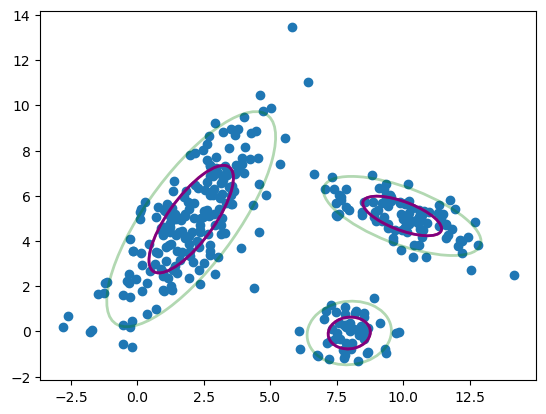

------
Class Probabilities
tf.Tensor([0.2864873  0.5713992  0.14286625], shape=(3,), dtype=float32)


NameError: name 'CLUSTER_PROBS' is not defined

In [33]:

# N_CLUSTERS = 2
# CLUSTER_PROBS = [0.3, 0.7]
# MUS_TRUE = [
#     [5.0, 5.0],
#     [-3.0, -2.0],
# ]
# COVS_TRUE = [
#     [
#         [1.5, 0.5],
#         [0.5, 2.0],
#     ],
#     [
#         [1.5, 0.0],
#         [0.0, 1.8],
#     ]
# ]
# N_SAMPLES = 1000

# # Batched Cholesky factorization of the covariance matrices
# LS_TRUE = tf.linalg.cholesky(COVS_TRUE)

# # The true Gaussian Mixture Model (we want to use for sampling some
# # artificial data)
# cat = tfp.distributions.Categorical(
#     probs=CLUSTER_PROBS,
# )
# normals = tfp.distributions.MultivariateNormalTriL(
#     loc=MUS_TRUE,
#     scale_tril=LS_TRUE,
# )

# gmm_true = tfp.distributions.MixtureSameFamily(
#     mixture_distribution=cat,
#     components_distribution=normals,
# )

# # tensor = tf.convert_to_tensor(numpy_array)

# dataset = gmm_true.sample(N_SAMPLES, seed=42)

# print(dataset.shape)

### Numpy
#---------------
N_CLUSTERS = 3
m1 = [2, 5]      # consider a random mean and covariance value
m2 = [10, 5]
m3 = [8, 0]

cov1 = [[4, 7],
        [1, 0]]

cov2 = [[-2, 1], 
        [-1, 0]]

cov3 = [[0.5, 0], 
        [0, -0.5]]

np.random.seed(42)

A = np.random.multivariate_normal(m1, cov1, size=(200,))  # Generating 200 samples for each mean and covariance
B = np.random.multivariate_normal(m2, cov2, size=(100,))
C = np.random.multivariate_normal(m3, cov3, size=(50,))

X = np.concatenate((A, B, C), axis=0)

dataset = tf.convert_to_tensor(X)
dataset = tf.cast(dataset, dtype=tf.float32)
# print(dataset.shape)
# print(dataset)
# plt.scatter(dataset.numpy()[:, 0], dataset.numpy()[:, 1])
# plt.show()

class_probs_approx, mus_approx, covs_approx = em(dataset, N_CLUSTERS)

print("------")
print("Class Probabilities")
print(class_probs_approx)
print(CLUSTER_PROBS)
print("------")
print("Mus")
print(mus_approx)
print(MUS_TRUE)
print("------")
print("Covariance Matrices")
print(covs_approx)
print(COVS_TRUE)



In [177]:
import numpy as np

# Assuming array1 and array2 are your numpy arrays
array1 = np.random.rand(350, 3, 2)  # Example random array of shape (350, 3, 2)
array2 = np.random.rand(2, 3, 350)  # Example random array of shape (2, 3, 350)

# Multiply the arrays
result = np.matmul(array1, array2)

# Result will have shape (350, 3, 3)
print("Shape of the result:", result.shape)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)